In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
from sqlalchemy import inspect

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

import datetime as dt

year_prior = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(year_prior)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
year_precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_prior, Measurement.prcp != None).\
    order_by(Measurement.date).all()


In [15]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names

# Sort the dataframe by date

year_precipitation_df = pd.DataFrame(year_precipitation_data, columns=['Date', 'Precipitation'])
year_precipitation_df.set_index('Date')
year_precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


<function matplotlib.pyplot.show(close=None, block=None)>

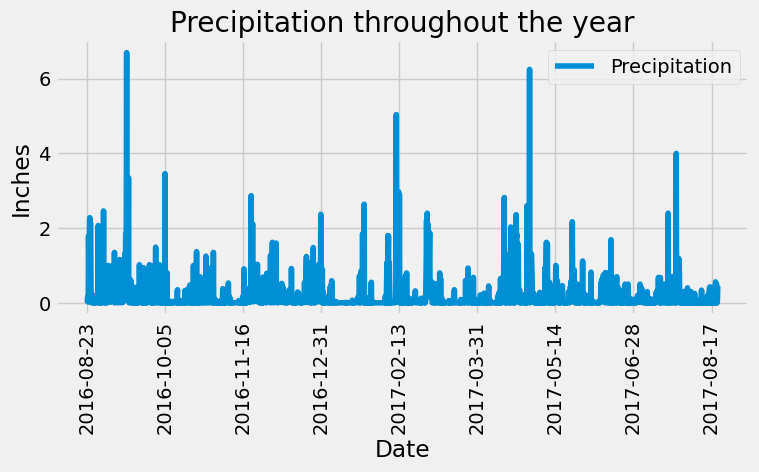

In [22]:

# Use Pandas Plotting with Matplotlib to plot the data
year_precipitation_df.plot(figsize=(8,4), x='Date')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation throughout the year')
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('Images/YearPrecipitation.png')
plt.show

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()

active_station_temps

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
year_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >=year_prior, Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).all()



In [34]:
year_temp_df = pd.DataFrame(year_temp, columns=['Tobs'])
year_temp_df.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


<function matplotlib.pyplot.show(close=None, block=None)>

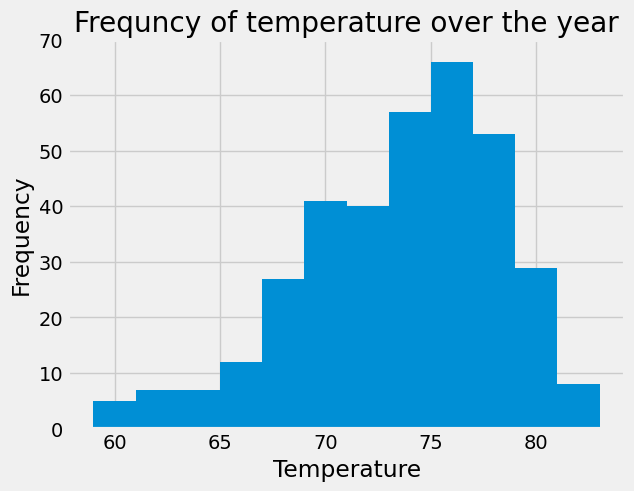

In [41]:
#Plot the results as a histogram
bins = 12
year_temp_df['Tobs'].plot.hist(bins=bins)
plt.ylim(0,70)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('Frequncy of temperature over the year')
plt.savefig('Images/YearTemperature.png')
plt.show

# Close Session

In [42]:
# Close Session
session.close()